In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

# COVID-19 Time-Series Case/Death Prediction

In this dataset, I would like to model the evolution of COVID-19 cases and deaths in the DMV area. I have a number of datasets from the CDC regarding cases, deaths, and vaccination rates per county, and I will do some small exploratory analyses to look at some potential relationships in order to decide on which features to add into the model. Additionally, I have a bunch of per-county metadata that I pulled from the latest (2019) census report. Unfortunately, a key piece of the puzzle (at least, in terms of predicting deaths) is the hospital utilization, but I haven't been able to find any per-county dataset with this information without scraping the Maryland COVID-19 Dashboard. I don't know how to do that.

My features:
- Longitudinal Features:
    - Cases
    - Deaths
    - Vaccination Rates
- Other Metadata:
    - Fertility Info
    - Health Insurance Characteristics
    - Private Health Insurance
    - Income
    - Poverty Status
    - Social/Demographic Characteristics
    - Work/Economic Characteristics
 
In total, there are 352 columns of non-longitudinal features. I will likely have to cull these down further when making models of the data. Details on how this data was cleaned can be shown in the other notebook (also attached).

## Some Final Cleaning

In [2]:
data = pd.read_csv("cases_deaths_vaccinations_byState_imputed.csv", sep=',', parse_dates=["date"])
data

,state,date,cases,deaths,total_distributed,distributed_per_hundred,people_fully_vaccinated_per_hundred,total_vaccinations_per_hundred,daily_vaccinations_per_million
0,Alabama,2021-01-12,3848,226,377025.0,7.69,0.1500,1.590,1205.0
1,Alabama,2021-01-13,3147,187,378975.0,7.73,0.1900,1.710,1205.0
2,Alabama,2021-01-14,3588,185,435350.0,8.88,0.2350,1.880,1445.0
3,Alabama,2021-01-15,2945,85,444650.0,9.07,0.2800,2.050,1525.0
4,Alabama,2021-01-16,3153,89,444650.0,9.07,0.2925,2.205,1529.0
...,...,...,...,...,...,...,...,...,...
12175,Wisconsin,2022-03-03,576,52,11106345.0,190.75,64.6600,169.700,846.0
12176,Wisconsin,2022-03-04,542,39,11114045.0,190.88,64.6900,169.810,999.0
12177,Wisconsin,2022-03-05,0,0,11118845.0,190.97,64.7100,169.900,824.0
12178,Wisconsin,2022-03-06,0,0,11118845.0,190.97,64.7400,169.990,835.0


In [3]:
searches = pd.read_csv("covid_searches_cleaned_imputed.csv", parse_dates=["date"])
keep_cols = [col for col in searches.columns if any(name in col for name in ["sub_region_1", "date", "symptom"])]
searches = searches[keep_cols]
newcols = ["state" if col == "sub_region_1" else col for col in searches.columns]
searches.columns = newcols
searches = searches[searches["date"] >= '2021-01-12']
searches

,state,date,symptom:pancreatitis,symptom:Hyperthyroidism,symptom:Headache,symptom:Heart arrhythmia,symptom:Heartburn,symptom:Hematochezia,symptom:Hematoma,symptom:Hematuria,...,symptom:Amenorrhea,symptom:Hydrocephalus,symptom:Nocturnal enuresis,symptom:Esophagitis,symptom:Polyuria,symptom:Upper respiratory tract infection,symptom:Granuloma,symptom:Hypocalcaemia,symptom:Asphyxia,symptom:Atheroma
11357,Alabama,2021-01-12,0.45,1.11,4.43,2.46,3.12,0.20,0.33,0.44,...,0.14,0.17,0.12,0.14,0.14,0.15,0.14,0.17,0.06,0.17
11358,Alabama,2021-01-13,0.39,1.02,4.41,2.30,3.02,0.19,0.36,0.44,...,0.13,0.18,0.11,0.17,0.14,0.19,0.15,0.14,0.09,0.11
11359,Alabama,2021-01-14,0.46,1.12,4.75,2.33,3.19,0.20,0.33,0.39,...,0.14,0.16,0.11,0.18,0.12,0.18,0.13,0.16,0.09,0.12
11360,Alabama,2021-01-15,0.38,1.02,4.40,2.17,3.08,0.21,0.35,0.36,...,0.12,0.15,0.10,0.14,0.15,0.17,0.11,0.17,0.11,0.14
11361,Alabama,2021-01-16,0.39,0.87,4.72,1.91,3.15,0.20,0.26,0.44,...,0.11,0.07,0.13,0.16,0.20,0.14,0.10,0.16,0.12,0.14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25942,Wisconsin,2022-04-12,0.35,1.09,3.74,3.01,2.20,0.17,0.35,0.38,...,0.11,0.15,0.12,0.11,0.11,0.18,0.18,0.15,0.08,0.12
25943,Wisconsin,2022-04-13,0.41,1.09,3.77,2.33,2.18,0.19,0.36,0.40,...,0.12,0.13,0.12,0.13,0.15,0.19,0.18,0.15,0.10,0.14
25944,Wisconsin,2022-04-14,0.36,1.06,3.50,2.03,2.15,0.20,0.36,0.40,...,0.09,0.12,0.13,0.10,0.09,0.15,0.19,0.20,0.09,0.14
25945,Wisconsin,2022-04-15,0.36,1.03,3.52,1.96,2.23,0.18,0.34,0.40,...,0.12,0.11,0.13,0.14,0.09,0.15,0.18,0.15,0.10,0.13


In [4]:
search_states = searches.state.unique()
cases_states = data.state.unique()

common_states = [state for state in search_states if state in cases_states]
len(common_states)

29

In [5]:
# keeping the states that are in common in both dataframes:

data = data[data['state'].isin(common_states)]
searches = searches[searches['state'].isin(common_states)]

I quickly want to make a new dataframe and test if any symptoms have correlations with the number of cases.

Text(0, 0.5, 'Observation')

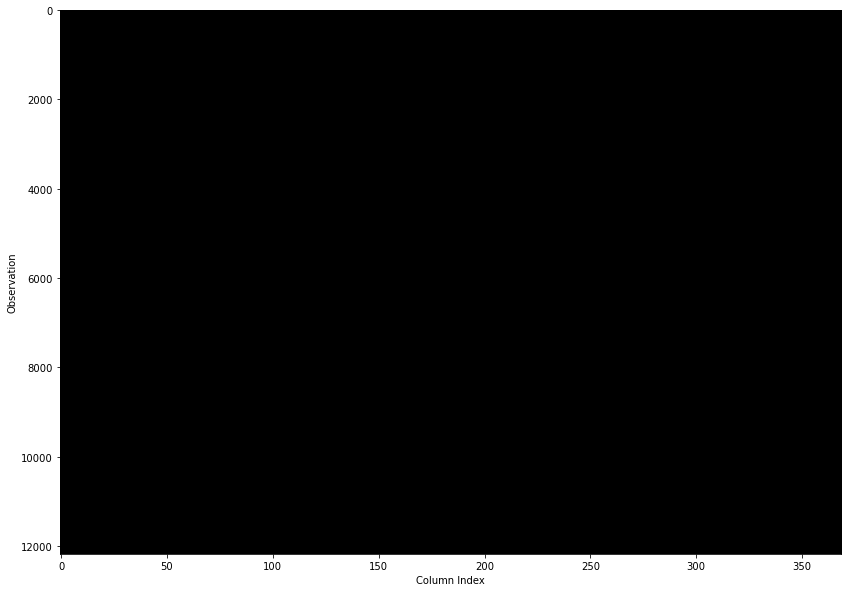

In [6]:
test_df = data.merge(searches, on=['state', 'date'], how='left')

fig, ax = plt.subplots(figsize=(14,10))
ax.imshow(test_df.isna(), aspect="auto", interpolation="nearest", cmap="gray")

ax.set_xlabel("Column Index")
ax.set_ylabel("Observation")

In [7]:
correlation = test_df.corr()
diag_mask = np.triu(np.ones_like(correlation, dtype=bool))
colors = sns.diverging_palette(230, 20, as_cmap=True)

<AxesSubplot:>

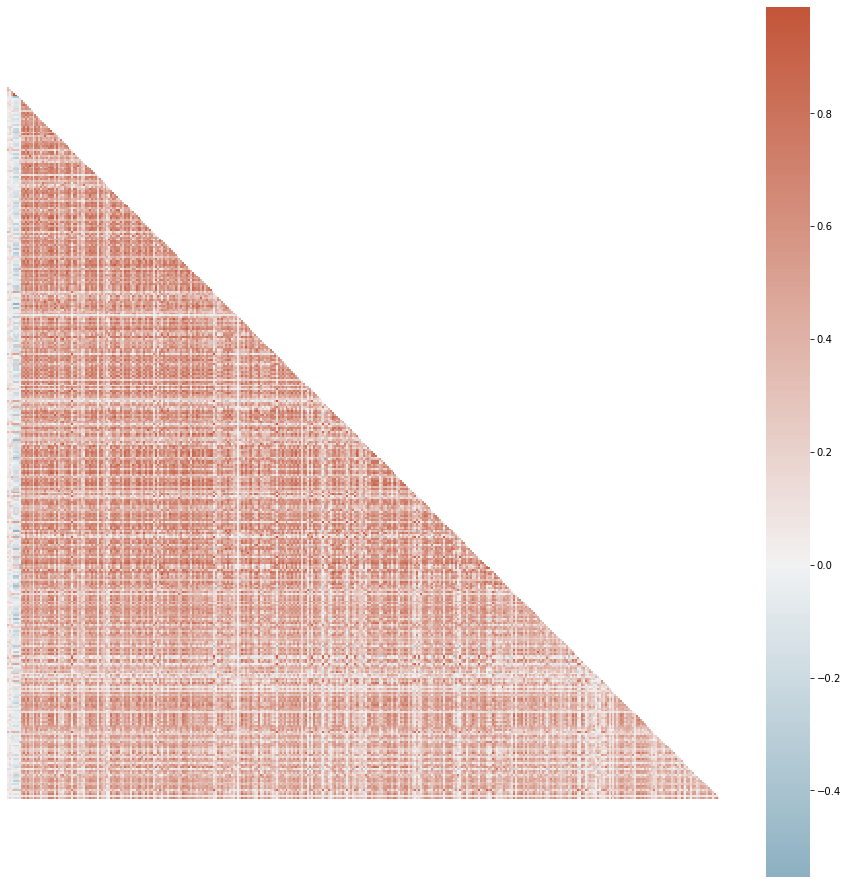

In [8]:
colors = sns.diverging_palette(230, 20, as_cmap=True)
plt.subplots(figsize=(16,16))
sns.heatmap(correlation, mask=diag_mask, center=0, square=True, cmap=colors,
           xticklabels = False, yticklabels = False)

Well, it's certainly true that the search data is highly correlated with itself. However, the correlations on the first four columns (i.e. with cases, deaths, and vaccinations) is nearly impossible to read. Let's take a closer look at it...

(As an aside, we would not expect any symptoms to be *negatively* correlated with case rates, so we are only interested in positive correlations).

In [9]:
correlation[correlation['cases'] > 0.10]['cases'].sort_values()

symptom:Stroke             0.100231
symptom:Eye strain         0.101608
symptom:Indigestion        0.102154
symptom:Tenderness         0.102551
symptom:Angioedema         0.103821
                             ...   
symptom:Chills             0.390512
total_distributed          0.397496
symptom:Fever              0.401799
symptom:Low-grade fever    0.417697
cases                      1.000000
Name: cases, Length: 76, dtype: float64

### An Easy Model: do google search patterns alone correlate with case rates?

While my goal is to ***predict*** case rates, a strong multiple linear regression may help us determine which features are useful to keep for the time series modeling. Right now, we have too many features to observations, so I would like to cull the number of features to those which appear most relevant. Unfortunately, we cannot do LDA since our dependent variables are not categorical (and not easily separable into categorical states without more information on what a "COVID Wave" is), so I will have to rely on this ad-hoc analysis.

In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [11]:
keep_cols = list(correlation[correlation['cases'] > 0.10]['cases'].sort_values().index)
len(keep_cols)

76

In [12]:
keep_cols.append("state")
keep_cols.append('date')



In [13]:
keep_cols

['symptom:Stroke',
 'symptom:Eye strain',
 'symptom:Indigestion',
 'symptom:Tenderness',
 'symptom:Angioedema',
 'symptom:Pleurisy',
 'symptom:Middle back pain',
 'symptom:Pleural effusion',
 'symptom:Delayed onset muscle soreness',
 'symptom:Migraine',
 'symptom:Periorbital puffiness',
 'symptom:Bruxism',
 'symptom:Compulsive behavior',
 'symptom:Shyness',
 'symptom:Periodontal disease',
 'symptom:Bleeding on probing',
 'symptom:Fatty liver disease',
 'symptom:Visual acuity',
 'symptom:Conjunctivitis',
 'symptom:Gingivitis',
 'symptom:Red eye',
 'symptom:Weakness',
 'symptom:Dry eye syndrome',
 'people_fully_vaccinated_per_hundred',
 'symptom:Xeroderma',
 'symptom:Hair loss',
 'symptom:Infection',
 'symptom:Inflammation',
 'symptom:Upper respiratory tract infection',
 'symptom:Wheeze',
 'symptom:Sleep disorder',
 'symptom:Chest pain',
 'symptom:Headache',
 'symptom:Cheilitis',
 'symptom:Erectile dysfunction',
 'symptom:Seborrheic dermatitis',
 'symptom:Eczema',
 'symptom:Insomnia',
 '

In [14]:
test_df_cut = test_df[keep_cols]
test_df_cut = test_df_cut.set_index(['state', 'date', "cases"]).reset_index()
test_df_cut

,state,date,cases,symptom:Stroke,symptom:Eye strain,symptom:Indigestion,symptom:Tenderness,symptom:Angioedema,symptom:Pleurisy,symptom:Middle back pain,...,symptom:Common cold,symptom:Phlegm,symptom:Pneumonia,symptom:Shivering,symptom:Sputum,symptom:Hypoxemia,symptom:Chills,total_distributed,symptom:Fever,symptom:Low-grade fever
0,Alabama,2021-01-12,3848,2.60,0.29,1.52,0.11,0.18,0.20,0.38,...,9.75,0.63,1.67,0.26,0.20,0.70,0.31,377025.0,3.88,0.28
1,Alabama,2021-01-13,3147,2.71,0.26,1.57,0.15,0.18,0.25,0.37,...,9.62,0.57,1.56,0.23,0.17,0.73,0.34,378975.0,3.92,0.27
2,Alabama,2021-01-14,3588,2.64,0.31,1.66,0.15,0.18,0.21,0.41,...,9.36,0.59,1.63,0.21,0.15,0.76,0.31,435350.0,4.06,0.28
3,Alabama,2021-01-15,2945,2.52,0.27,1.55,0.16,0.15,0.19,0.36,...,9.17,0.64,1.59,0.21,0.16,0.71,0.30,444650.0,3.81,0.27
4,Alabama,2021-01-16,3153,2.30,0.27,1.67,0.14,0.24,0.20,0.38,...,9.73,0.65,1.28,0.26,0.14,0.73,0.30,444650.0,3.78,0.26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12175,Wisconsin,2022-03-03,576,2.69,0.23,1.30,0.15,0.23,0.10,0.27,...,8.38,0.63,1.05,0.19,0.17,0.24,0.25,11106345.0,2.89,0.14
12176,Wisconsin,2022-03-04,542,2.46,0.20,1.28,0.11,0.20,0.11,0.26,...,7.90,0.55,0.94,0.17,0.15,0.25,0.24,11114045.0,2.80,0.09
12177,Wisconsin,2022-03-05,0,2.06,0.17,1.49,0.12,0.18,0.11,0.29,...,8.50,0.63,0.85,0.18,0.12,0.24,0.22,11118845.0,2.93,0.15
12178,Wisconsin,2022-03-06,0,2.09,0.16,1.58,0.13,0.18,0.11,0.25,...,8.73,0.66,0.93,0.20,0.15,0.25,0.26,11118845.0,2.98,0.13


In [15]:
test_df_cut2 = test_df_cut.drop(["state", "date"], axis=1)

In [16]:
X_train, X_val, y_train, y_val = train_test_split(test_df_cut2.drop("cases", axis=1),
                                                  test_df_cut2["cases"],
                                                  test_size=0.2,
                                                  random_state=1)

mlr = LinearRegression()
mlr.fit(X_train, y_train)

LinearRegression()

In [17]:
y_val_pred = mlr.predict(X_val)


In [18]:
mean_squared_error(y_true = y_val, y_pred = y_val_pred)

40857141.97878951

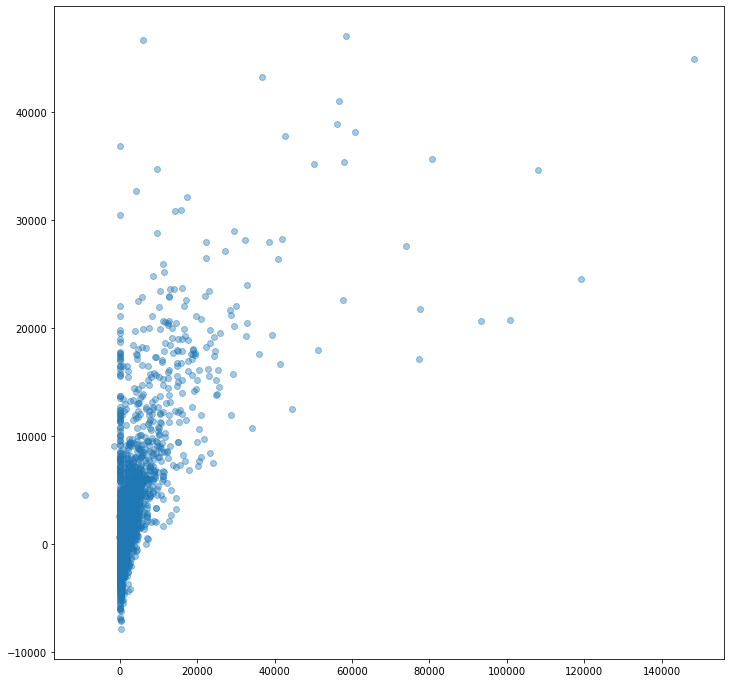

In [19]:
fig, ax = plt.subplots(figsize = (12,12))

ax.scatter(y_val, y_val_pred, alpha = 0.4)

In [20]:
mlr.score(X_val, y_val)

0.4153539355620952

The R<sup>2</sup> is 0.415, which suggests that these combined features are useful but not entirely predictive of the case rate. This is perhaps not too surprising, as there are other important aspects that would influence the relationship between searches and cases, including the state, the date, and the demographic information. At the very least, this is useful to verify that our search information will aid our model, and it provides a benchmark for us to beat later.

The scatterplot shows that there are a bunch of '0' values, as expected. However, the linear regression appears to poorly predict when the case rates are low. This may be because google search trends are reported daily, while cases and deaths are not reported on the weekends for many states. I will keep this in the back of my mind as I continue. 

It seems like the relationship between symptom searches and cases is nonlinear, and there is a strong right skew to our data (many low case values, few high case values). To redo this sort of non-time-series analysis, we may need to upsample our observations with higher case reports, and downsample our 0's. Either that, or we will need to perform some sort of boosting.

The key reason to use any time series model is *autoregression* -- that is, predicted values are at least partially dependent on the value of the previous timepoint. Let's add the previous time point as a feature on the linear model to see whether it improves the prediction.

In [21]:
test_df_cut4 = test_df_cut.set_index(["state", "date"])
test_df_cut4.loc['Alabama', '2021-01-12']['cases']

3848.0

In [22]:
test_df_cut[(test_df_cut['state'] == 'Alabama') & (test_df_cut['date'] == '2021-01-12')]['state']

0    Alabama
Name: state, dtype: object

In [23]:
from datetime import timedelta
test_df_cut3 = test_df_cut.copy()
test_df_cut3['date'] = np.vectorize(pd.to_datetime)(test_df_cut3['date'])
test_df_cut3['yesterday'] = test_df_cut3['date'] - timedelta(days=1)
test_df_cut3 = test_df_cut3.set_index(['state', 'date', 'cases', 'yesterday']).reset_index()
test_df_cut3 = test_df_cut3.set_index(['state','date'])
test_df_cut3['yesterday_val'] = -1

test_df_cut3.head()
    


cases  yesterday  symptom:Stroke  symptom:Eye strain  \
state   date                                                               
Alabama 2021-01-12   3848 2021-01-11            2.60                0.29   
        2021-01-13   3147 2021-01-12            2.71                0.26   
        2021-01-14   3588 2021-01-13            2.64                0.31   
        2021-01-15   2945 2021-01-14            2.52                0.27   
        2021-01-16   3153 2021-01-15            2.30                0.27   

                    symptom:Indigestion  symptom:Tenderness  \
state   date                                                  
Alabama 2021-01-12                 1.52                0.11   
        2021-01-13                 1.57                0.15   
        2021-01-14                 1.66                0.15   
        2021-01-15                 1.55                0.16   
        2021-01-16                 1.67                0.14   

                    symptom:Angioedema  symptom:Pleurisy  \
state   date                                               
Alabama 2021-01-12                0.18              0.20   
        2021-01-13                0.18              0.25   
        2021-01-14                0.18              0.21   
        2021-01-15                0.15              0.19   
        2021-01-16                0.24              0.20   

                    symptom:Middle back pain  symptom:Pleural effusion  ...  \
state   date                                                            ...   
Alabama 2021-01-12                      0.38                      0.22  ...   
        2021-01-13                      0.37                      0.23  ...   
        2021-01-14                      0.41                      0.29  ...   
        2021-01-15                      0.36                      0.30  ...   
        2021-01-16                      0.38                      0.17  ...   

                    symptom:Phlegm  symptom:Pneumonia  symptom:Shivering  \
state   date                                                               
Alabama 2021-01-12            0.63               1.67               0.26   
        2021-01-13            0.57               1.56               0.23   
        2021-01-14            0.59               1.63               0.21   
        2021-01-15            0.64               1.59               0.21   
        2021-01-16            0.65               1.28               0.26   

                    symptom:Sputum  symptom:Hypoxemia  symptom:Chills  \
state   date                                                            
Alabama 2021-01-12            0.20               0.70            0.31   
        2021-01-13            0.17               0.73            0.34   
        2021-01-14            0.15               0.76            0.31   
        2021-01-15            0.16               0.71            0.30   
        2021-01-16            0.14               0.73            0.30   

                    total_distributed  symptom:Fever  symptom:Low-grade fever  \
state   date                                                                    
Alabama 2021-01-12           377025.0           3.88                     0.28   
        2021-01-13           378975.0           3.92                     0.27   
        2021-01-14           435350.0           4.06                     0.28   
        2021-01-15           444650.0           3.81                     0.27   
        2021-01-16           444650.0           3.78                     0.26   

                    yesterday_val  
state   date                       
Alabama 2021-01-12             -1  
        2021-01-13             -1  
        2021-01-14             -1  
        2021-01-15             -1  
        2021-01-16             -1  

[5 rows x 78 columns]

In [24]:
test_df_cut3.index[0][0]

'Alabama'

In [25]:
for i in range(0, test_df_cut3.shape[0]):
    state = test_df_cut3.index[i][0]
    yesterday_date = test_df_cut3.iloc[i,1].date()
    date = str(pd.to_datetime(yesterday_date + timedelta(days=1)).date())
    yesterday_date = str(yesterday_date)
    if yesterday_date == '2021-01-11':
        test_df_cut3['yesterday_val'][i] = test_df_cut3.loc[state, date]['cases']
    else:
        test_df_cut3['yesterday_val'][i] = test_df_cut3.loc[state, yesterday_date]['cases']

test_df_cut3.head()

/var/folders/nn/04fg5y513pdg807378fs9m7cpm0jsw/T/ipykernel_48758/1511630002.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df_cut3['yesterday_val'][i] = test_df_cut3.loc[state, date]['cases']
/var/folders/nn/04fg5y513pdg807378fs9m7cpm0jsw/T/ipykernel_48758/1511630002.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df_cut3['yesterday_val'][i] = test_df_cut3.loc[state, yesterday_date]['cases']


cases  yesterday  symptom:Stroke  symptom:Eye strain  \
state   date                                                               
Alabama 2021-01-12   3848 2021-01-11            2.60                0.29   
        2021-01-13   3147 2021-01-12            2.71                0.26   
        2021-01-14   3588 2021-01-13            2.64                0.31   
        2021-01-15   2945 2021-01-14            2.52                0.27   
        2021-01-16   3153 2021-01-15            2.30                0.27   

                    symptom:Indigestion  symptom:Tenderness  \
state   date                                                  
Alabama 2021-01-12                 1.52                0.11   
        2021-01-13                 1.57                0.15   
        2021-01-14                 1.66                0.15   
        2021-01-15                 1.55                0.16   
        2021-01-16                 1.67                0.14   

                    symptom:Angioedema  symptom:Pleurisy  \
state   date                                               
Alabama 2021-01-12                0.18              0.20   
        2021-01-13                0.18              0.25   
        2021-01-14                0.18              0.21   
        2021-01-15                0.15              0.19   
        2021-01-16                0.24              0.20   

                    symptom:Middle back pain  symptom:Pleural effusion  ...  \
state   date                                                            ...   
Alabama 2021-01-12                      0.38                      0.22  ...   
        2021-01-13                      0.37                      0.23  ...   
        2021-01-14                      0.41                      0.29  ...   
        2021-01-15                      0.36                      0.30  ...   
        2021-01-16                      0.38                      0.17  ...   

                    symptom:Phlegm  symptom:Pneumonia  symptom:Shivering  \
state   date                                                               
Alabama 2021-01-12            0.63               1.67               0.26   
        2021-01-13            0.57               1.56               0.23   
        2021-01-14            0.59               1.63               0.21   
        2021-01-15            0.64               1.59               0.21   
        2021-01-16            0.65               1.28               0.26   

                    symptom:Sputum  symptom:Hypoxemia  symptom:Chills  \
state   date                                                            
Alabama 2021-01-12            0.20               0.70            0.31   
        2021-01-13            0.17               0.73            0.34   
        2021-01-14            0.15               0.76            0.31   
        2021-01-15            0.16               0.71            0.30   
        2021-01-16            0.14               0.73            0.30   

                    total_distributed  symptom:Fever  symptom:Low-grade fever  \
state   date                                                                    
Alabama 2021-01-12           377025.0           3.88                     0.28   
        2021-01-13           378975.0           3.92                     0.27   
        2021-01-14           435350.0           4.06                     0.28   
        2021-01-15           444650.0           3.81                     0.27   
        2021-01-16           444650.0           3.78                     0.26   

                    yesterday_val  
state   date                       
Alabama 2021-01-12           3848  
        2021-01-13           3848  
        2021-01-14           3147  
        2021-01-15           3588  
        2021-01-16           2945  

[5 rows x 78 columns]

In [26]:
test_df_cut3.columns

Index(['cases', 'yesterday', 'symptom:Stroke', 'symptom:Eye strain',
       'symptom:Indigestion', 'symptom:Tenderness', 'symptom:Angioedema',
       'symptom:Pleurisy', 'symptom:Middle back pain',
       'symptom:Pleural effusion', 'symptom:Delayed onset muscle soreness',
       'symptom:Migraine', 'symptom:Periorbital puffiness', 'symptom:Bruxism',
       'symptom:Compulsive behavior', 'symptom:Shyness',
       'symptom:Periodontal disease', 'symptom:Bleeding on probing',
       'symptom:Fatty liver disease', 'symptom:Visual acuity',
       'symptom:Conjunctivitis', 'symptom:Gingivitis', 'symptom:Red eye',
       'symptom:Weakness', 'symptom:Dry eye syndrome',
       'people_fully_vaccinated_per_hundred', 'symptom:Xeroderma',
       'symptom:Hair loss', 'symptom:Infection', 'symptom:Inflammation',
       'symptom:Upper respiratory tract infection', 'symptom:Wheeze',
       'symptom:Sleep disorder', 'symptom:Chest pain', 'symptom:Headache',
       'symptom:Cheilitis', 'symptom:Erectil

In [27]:
test_df_cut4 = test_df_cut3.drop('yesterday', axis=1)
test_df_cut4 = test_df_cut4.reset_index(drop=True).set_index(['cases', 'yesterday_val']).reset_index()
test_df_cut4.head()

,cases,yesterday_val,symptom:Stroke,symptom:Eye strain,symptom:Indigestion,symptom:Tenderness,symptom:Angioedema,symptom:Pleurisy,symptom:Middle back pain,symptom:Pleural effusion,...,symptom:Common cold,symptom:Phlegm,symptom:Pneumonia,symptom:Shivering,symptom:Sputum,symptom:Hypoxemia,symptom:Chills,total_distributed,symptom:Fever,symptom:Low-grade fever
0,3848,3848,2.60,0.29,1.52,0.11,0.18,0.20,0.38,0.22,...,9.75,0.63,1.67,0.26,0.20,0.70,0.31,377025.0,3.88,0.28
1,3147,3848,2.71,0.26,1.57,0.15,0.18,0.25,0.37,0.23,...,9.62,0.57,1.56,0.23,0.17,0.73,0.34,378975.0,3.92,0.27
2,3588,3147,2.64,0.31,1.66,0.15,0.18,0.21,0.41,0.29,...,9.36,0.59,1.63,0.21,0.15,0.76,0.31,435350.0,4.06,0.28
3,2945,3588,2.52,0.27,1.55,0.16,0.15,0.19,0.36,0.30,...,9.17,0.64,1.59,0.21,0.16,0.71,0.30,444650.0,3.81,0.27
4,3153,2945,2.30,0.27,1.67,0.14,0.24,0.20,0.38,0.17,...,9.73,0.65,1.28,0.26,0.14,0.73,0.30,444650.0,3.78,0.26


In [28]:
df = test_df_cut3.copy()

In [29]:
df_yesterdayVal = test_df_cut4.copy()
del test_df_cut4
del test_df_cut3
del test_df_cut2
df_yesterdayVal.head()

,cases,yesterday_val,symptom:Stroke,symptom:Eye strain,symptom:Indigestion,symptom:Tenderness,symptom:Angioedema,symptom:Pleurisy,symptom:Middle back pain,symptom:Pleural effusion,...,symptom:Common cold,symptom:Phlegm,symptom:Pneumonia,symptom:Shivering,symptom:Sputum,symptom:Hypoxemia,symptom:Chills,total_distributed,symptom:Fever,symptom:Low-grade fever
0,3848,3848,2.60,0.29,1.52,0.11,0.18,0.20,0.38,0.22,...,9.75,0.63,1.67,0.26,0.20,0.70,0.31,377025.0,3.88,0.28
1,3147,3848,2.71,0.26,1.57,0.15,0.18,0.25,0.37,0.23,...,9.62,0.57,1.56,0.23,0.17,0.73,0.34,378975.0,3.92,0.27
2,3588,3147,2.64,0.31,1.66,0.15,0.18,0.21,0.41,0.29,...,9.36,0.59,1.63,0.21,0.15,0.76,0.31,435350.0,4.06,0.28
3,2945,3588,2.52,0.27,1.55,0.16,0.15,0.19,0.36,0.30,...,9.17,0.64,1.59,0.21,0.16,0.71,0.30,444650.0,3.81,0.27
4,3153,2945,2.30,0.27,1.67,0.14,0.24,0.20,0.38,0.17,...,9.73,0.65,1.28,0.26,0.14,0.73,0.30,444650.0,3.78,0.26


Now, let's re-split the new dataframe and fit a multiple linear model to the data.

In [30]:
X_train, X_val, y_train, y_val = train_test_split(df_yesterdayVal.drop("cases", axis=1),
                                                  df_yesterdayVal["cases"],
                                                  test_size=0.2,
                                                  random_state=1)

mlr = LinearRegression()
mlr.fit(X_train, y_train)

LinearRegression()

In [31]:
y_val_pred = mlr.predict(X_val)

Text(0, 0.5, 'Predicted Cases Value')

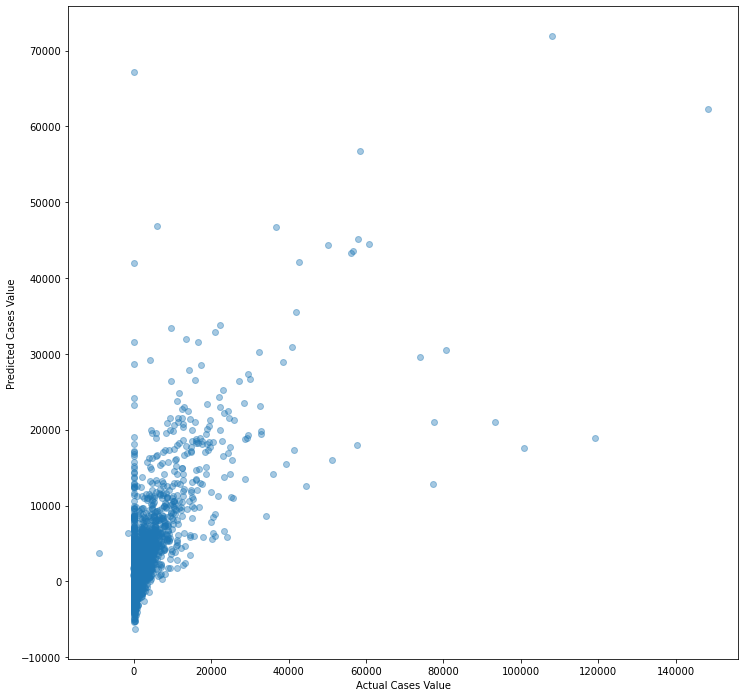

In [32]:
fig, ax = plt.subplots(figsize = (12,12))

ax.scatter(y_val, y_val_pred, alpha = 0.4)
ax.set_xlabel("Actual Cases Value")
ax.set_ylabel("Predicted Cases Value")

In [33]:
mse_auto = mean_squared_error(y_true = y_val, y_pred = y_val_pred)
r2_auto = mlr.score(X_val, y_val)
print(f"MSE: {mse_auto}; R2: {r2_auto}")

MSE: 37782975.411025316; R2: 0.45934378160181477


So, the R<sup>2</sup> is greater than the previous (0.41). Next, we'll remove the yesterday_val column and retrain the model so that we can see the difference.

I am still seeing that the linear regression is highly affected by the few high-cases values, and most large mispredictions appear to be when actual cases = 0. Chances are that this is because of a state-wide lapse on reporting over the weekends. Unfortunately bayesian ridge regression cannot take categorical data, so I can't add day of the week as another feature.

In [34]:
X_train, X_val, y_train, y_val = train_test_split(df_yesterdayVal.drop(["cases",'yesterday_val'], axis=1),
                                                  df_yesterdayVal["cases"],
                                                  test_size=0.2,
                                                  random_state=1)

mlr_noAutoRegression = LinearRegression()
mlr_noAutoRegression.fit(X_train, y_train)

LinearRegression()

In [35]:
y_val_pred = mlr_noAutoRegression.predict(X_val)

In [36]:
mse = mean_squared_error(y_true = y_val, y_pred = y_val_pred)
r2 = mlr_noAutoRegression.score(X_val, y_val)
print(f"MSE: {mse}; R^2: {r2}")

MSE: 40857141.97878951; R^2: 0.4153539355620952


In [37]:
### comparing to the previous model with pseudo-autoregression:
print(f"MSE: {mse_auto}; R2: {r2_auto}")

MSE: 37782975.411025316; R2: 0.45934378160181477


The model with pseudo-autoregression does indeed look better.

Finally, since the google search trends are highly correlated with each other, let's perform dimensionality reduction to summarize these into a smaller number of features, and see if it improves the model.

In [38]:
df_yesterdayVal.head()

,cases,yesterday_val,symptom:Stroke,symptom:Eye strain,symptom:Indigestion,symptom:Tenderness,symptom:Angioedema,symptom:Pleurisy,symptom:Middle back pain,symptom:Pleural effusion,...,symptom:Common cold,symptom:Phlegm,symptom:Pneumonia,symptom:Shivering,symptom:Sputum,symptom:Hypoxemia,symptom:Chills,total_distributed,symptom:Fever,symptom:Low-grade fever
0,3848,3848,2.60,0.29,1.52,0.11,0.18,0.20,0.38,0.22,...,9.75,0.63,1.67,0.26,0.20,0.70,0.31,377025.0,3.88,0.28
1,3147,3848,2.71,0.26,1.57,0.15,0.18,0.25,0.37,0.23,...,9.62,0.57,1.56,0.23,0.17,0.73,0.34,378975.0,3.92,0.27
2,3588,3147,2.64,0.31,1.66,0.15,0.18,0.21,0.41,0.29,...,9.36,0.59,1.63,0.21,0.15,0.76,0.31,435350.0,4.06,0.28
3,2945,3588,2.52,0.27,1.55,0.16,0.15,0.19,0.36,0.30,...,9.17,0.64,1.59,0.21,0.16,0.71,0.30,444650.0,3.81,0.27
4,3153,2945,2.30,0.27,1.67,0.14,0.24,0.20,0.38,0.17,...,9.73,0.65,1.28,0.26,0.14,0.73,0.30,444650.0,3.78,0.26


In [39]:
df_yesterdayVal.shape

(12180, 77)

In [40]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
symptoms = scaler.fit_transform(df_yesterdayVal.drop(['cases', 'yesterday_val'], axis=1))
symptoms

array([[ 0.16440738,  1.21143294,  0.54144734, ..., -0.87476411,
         0.14318761,  0.58522188],
       [ 0.39373421,  0.6340184 ,  0.78763143, ..., -0.87460466,
         0.18190866,  0.49332658],
       [ 0.24779895,  1.59637597,  1.23076278, ..., -0.86999499,
         0.31743233,  0.58522188],
       ...,
       [-0.96137887, -1.09822524,  0.39373689, ...,  0.00357195,
        -0.77643731, -0.60941697],
       [-0.89883519, -1.29069675,  0.83686824, ...,  0.00357195,
        -0.72803599, -0.79320757],
       [ 0.39373421, -0.52081069,  0.29526325, ...,  0.00357195,
        -0.56347154, -0.51752168]])

In [41]:
pd.DataFrame(symptoms).shape

(12180, 75)

In [42]:
from sklearn.decomposition import PCA

PCA_model = PCA(n_components = 0.99, svd_solver='full', random_state=42)

symptoms_reduced = PCA_model.fit_transform(symptoms)
pd.DataFrame(symptoms_reduced)

,0,1,2,3,4,5,6,7,8,9,...,44,45,46,47,48,49,50,51,52,53
0,4.053560,-2.700041,-2.284608,4.942385,1.635590,1.023781,1.232463,1.744645,0.412867,-0.070500,...,0.609683,0.251215,-0.007384,-0.002533,0.249602,-0.440434,0.068243,0.134150,0.475602,0.277588
1,4.892441,-3.205614,-2.037197,4.948722,0.768236,1.826688,1.543968,1.434465,0.069210,-0.450154,...,0.043990,0.139885,-0.025825,0.074080,-0.033181,-0.166354,-0.243129,-0.235045,0.064831,0.998404
2,5.585716,-4.370715,-2.058669,5.038309,0.686245,0.824234,1.295779,0.985054,1.104043,0.522380,...,-0.169733,0.433852,-0.247609,0.013361,-0.020977,0.012738,-0.289296,-0.135274,0.508360,0.547310
3,2.856177,-2.335473,-1.799318,5.238215,0.079485,0.892549,1.857924,0.868803,0.371301,-0.569637,...,-0.082733,-0.019867,0.306139,0.393464,-0.040515,-0.157594,-0.161277,0.281409,0.167644,0.528260
4,4.255562,-2.386167,1.367315,6.514948,-1.386676,1.863909,0.962640,0.847513,1.012597,-0.392493,...,0.702381,0.165902,0.032192,0.352266,0.267538,-0.771010,-0.124425,0.028305,-0.244993,0.056356
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12175,-1.141855,-0.158200,-0.363326,-2.617517,-0.370583,1.792130,-0.823626,0.425746,0.359814,-0.056566,...,-0.339683,-0.338442,0.402259,-0.611740,-0.365138,-0.215542,-0.300425,-0.134292,-0.172334,-0.044713
12176,-4.433438,1.824651,-0.588384,-2.060923,-0.913058,1.512949,0.424039,0.113313,0.514374,-0.335115,...,0.119006,-0.335396,0.173176,-0.455725,-0.341715,0.095271,-0.168856,-0.113933,-0.096613,-0.063715
12177,-4.819128,2.747649,1.793261,-0.405320,-2.344527,1.752137,-0.310856,0.335731,0.904737,-0.466253,...,-0.191125,0.163168,0.198082,0.160162,-0.359300,-0.249998,-0.240911,-0.237262,0.132678,0.195617
12178,-2.572964,1.569508,2.174764,-0.994683,-1.411891,1.941128,-0.222853,-0.541077,1.291253,0.144803,...,0.020846,0.047205,-0.592612,0.550590,-0.722397,0.433760,0.149884,0.346658,-0.067699,0.072949


In [43]:
## explained variance for each dimension of the PCA.
PCA_model.explained_variance_ratio_

array([0.42695553, 0.17662407, 0.06641827, 0.05382216, 0.03285188,
       0.02176889, 0.01979483, 0.01367557, 0.01348862, 0.01217098,
       0.0098653 , 0.0085892 , 0.00831802, 0.00710503, 0.00667397,
       0.00640445, 0.00603871, 0.00571159, 0.0054686 , 0.00532067,
       0.00483134, 0.00436502, 0.00431332, 0.00417227, 0.00394536,
       0.00378818, 0.00358916, 0.00348121, 0.00336263, 0.00314683,
       0.00302037, 0.00291779, 0.00276   , 0.00263545, 0.0025649 ,
       0.00247622, 0.00239795, 0.00234732, 0.00224094, 0.00209398,
       0.00193617, 0.00183301, 0.00176878, 0.00164064, 0.00156432,
       0.00146286, 0.00136375, 0.00131594, 0.00123909, 0.00113562,
       0.00107564, 0.00105332, 0.00098884, 0.00090642])

In [44]:
df_yesterdayVal_symptomReduced = df_yesterdayVal[["cases","yesterday_val"]].merge(pd.DataFrame(symptoms_reduced),
                                                                                  left_index=True,
                                                                                  right_index=True,
                                                                                  how='left')
df_yesterdayVal_symptomReduced

,cases,yesterday_val,0,1,2,3,4,5,6,7,...,44,45,46,47,48,49,50,51,52,53
0,3848,3848,4.053560,-2.700041,-2.284608,4.942385,1.635590,1.023781,1.232463,1.744645,...,0.609683,0.251215,-0.007384,-0.002533,0.249602,-0.440434,0.068243,0.134150,0.475602,0.277588
1,3147,3848,4.892441,-3.205614,-2.037197,4.948722,0.768236,1.826688,1.543968,1.434465,...,0.043990,0.139885,-0.025825,0.074080,-0.033181,-0.166354,-0.243129,-0.235045,0.064831,0.998404
2,3588,3147,5.585716,-4.370715,-2.058669,5.038309,0.686245,0.824234,1.295779,0.985054,...,-0.169733,0.433852,-0.247609,0.013361,-0.020977,0.012738,-0.289296,-0.135274,0.508360,0.547310
3,2945,3588,2.856177,-2.335473,-1.799318,5.238215,0.079485,0.892549,1.857924,0.868803,...,-0.082733,-0.019867,0.306139,0.393464,-0.040515,-0.157594,-0.161277,0.281409,0.167644,0.528260
4,3153,2945,4.255562,-2.386167,1.367315,6.514948,-1.386676,1.863909,0.962640,0.847513,...,0.702381,0.165902,0.032192,0.352266,0.267538,-0.771010,-0.124425,0.028305,-0.244993,0.056356
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12175,576,781,-1.141855,-0.158200,-0.363326,-2.617517,-0.370583,1.792130,-0.823626,0.425746,...,-0.339683,-0.338442,0.402259,-0.611740,-0.365138,-0.215542,-0.300425,-0.134292,-0.172334,-0.044713
12176,542,576,-4.433438,1.824651,-0.588384,-2.060923,-0.913058,1.512949,0.424039,0.113313,...,0.119006,-0.335396,0.173176,-0.455725,-0.341715,0.095271,-0.168856,-0.113933,-0.096613,-0.063715
12177,0,542,-4.819128,2.747649,1.793261,-0.405320,-2.344527,1.752137,-0.310856,0.335731,...,-0.191125,0.163168,0.198082,0.160162,-0.359300,-0.249998,-0.240911,-0.237262,0.132678,0.195617
12178,0,0,-2.572964,1.569508,2.174764,-0.994683,-1.411891,1.941128,-0.222853,-0.541077,...,0.020846,0.047205,-0.592612,0.550590,-0.722397,0.433760,0.149884,0.346658,-0.067699,0.072949


In [45]:
X_train, X_val, y_train, y_val = train_test_split(df_yesterdayVal_symptomReduced.drop(["cases",'yesterday_val'], axis=1),
                                                  df_yesterdayVal_symptomReduced["cases"],
                                                  test_size=0.2,
                                                  random_state=1)

mlr_reduced = LinearRegression()
mlr_reduced.fit(X_train, y_train)

LinearRegression()

In [46]:
y_val_pred = mlr_reduced.predict(X_val)

In [47]:
mse = mean_squared_error(y_true = y_val, y_pred = y_val_pred)
r2 = mlr_reduced.score(X_val, y_val)
print(f"MSE: {mse}; R^2: {r2}")

MSE: 41922598.28010612; R^2: 0.4001077679833962


Explained variance went down in this case, perhaps adding two methods to prevent overfitting removed important features. Perhaps this is because L2

Furthermore, this test confirms to me that the autoregressive linear model is too simple (high bias, underfit) to model our data. At least, this shows us that there is important information in our features to model case rates, so there is some rationale to try a more general model.

Finally, our EDA found that there is cyclical structure to the time series -- certain days of the week have no reporting of cases and deaths. Let's add the day of the week to the model to see how it improves a simple regression.

In [48]:
df = df.drop('yesterday', axis=1)
df

cases  symptom:Stroke  symptom:Eye strain  \
state     date                                                    
Alabama   2021-01-12   3848            2.60                0.29   
          2021-01-13   3147            2.71                0.26   
          2021-01-14   3588            2.64                0.31   
          2021-01-15   2945            2.52                0.27   
          2021-01-16   3153            2.30                0.27   
...                     ...             ...                 ...   
Wisconsin 2022-03-03    576            2.69                0.23   
          2022-03-04    542            2.46                0.20   
          2022-03-05      0            2.06                0.17   
          2022-03-06      0            2.09                0.16   
          2022-03-07   1131            2.71                0.20   

                      symptom:Indigestion  symptom:Tenderness  \
state     date                                                  
Alabama   2021-01-12                 1.52                0.11   
          2021-01-13                 1.57                0.15   
          2021-01-14                 1.66                0.15   
          2021-01-15                 1.55                0.16   
          2021-01-16                 1.67                0.14   
...                                   ...                 ...   
Wisconsin 2022-03-03                 1.30                0.15   
          2022-03-04                 1.28                0.11   
          2022-03-05                 1.49                0.12   
          2022-03-06                 1.58                0.13   
          2022-03-07                 1.47                0.16   

                      symptom:Angioedema  symptom:Pleurisy  \
state     date                                               
Alabama   2021-01-12                0.18              0.20   
          2021-01-13                0.18              0.25   
          2021-01-14                0.18              0.21   
          2021-01-15                0.15              0.19   
          2021-01-16                0.24              0.20   
...                                  ...               ...   
Wisconsin 2022-03-03                0.23              0.10   
          2022-03-04                0.20              0.11   
          2022-03-05                0.18              0.11   
          2022-03-06                0.18              0.11   
          2022-03-07                0.18              0.12   

                      symptom:Middle back pain  symptom:Pleural effusion  \
state     date                                                             
Alabama   2021-01-12                      0.38                      0.22   
          2021-01-13                      0.37                      0.23   
          2021-01-14                      0.41                      0.29   
          2021-01-15                      0.36                      0.30   
          2021-01-16                      0.38                      0.17   
...                                        ...                       ...   
Wisconsin 2022-03-03                      0.27                      0.28   
          2022-03-04                      0.26                      0.23   
          2022-03-05                      0.29                      0.19   
          2022-03-06                      0.25                      0.22   
          2022-03-07                      0.34                      0.24   

                      symptom:Delayed onset muscle soreness  ...  \
state     date                                               ...   
Alabama   2021-01-12                                   0.50  ...   
          2021-01-13                                   0.54  ...   
          2021-01-14                                   0.63  ...   
          2021-01-15                                   0.52  ...   
          2021-01-16                                   0.50  ...   
...                             

In [49]:
df['day_of_week'] = df.index.get_level_values('date').day_name()


In [51]:
df = df.reset_index()

In [52]:
from sklearn.preprocessing import OneHotEncoder

In [53]:
# We need to one-hot encode day_of_week

ohe = OneHotEncoder()

series = ohe.fit_transform(df[['day_of_week']])
series = series.toarray()
series

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

In [54]:
series = pd.DataFrame(series, columns = ['col1', 'col2', 'col3', 'col4',
                                         'col5', 'col6', 'col7'])

df_ohe = df.merge(series, left_index=True, right_index=True, how='outer')
df_ohe.head()

,state,date,cases,symptom:Stroke,symptom:Eye strain,symptom:Indigestion,symptom:Tenderness,symptom:Angioedema,symptom:Pleurisy,symptom:Middle back pain,...,symptom:Low-grade fever,yesterday_val,day_of_week,col1,col2,col3,col4,col5,col6,col7
0,Alabama,2021-01-12,3848,2.60,0.29,1.52,0.11,0.18,0.20,0.38,...,0.28,3848,Tuesday,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,Alabama,2021-01-13,3147,2.71,0.26,1.57,0.15,0.18,0.25,0.37,...,0.27,3848,Wednesday,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,Alabama,2021-01-14,3588,2.64,0.31,1.66,0.15,0.18,0.21,0.41,...,0.28,3147,Thursday,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,Alabama,2021-01-15,2945,2.52,0.27,1.55,0.16,0.15,0.19,0.36,...,0.27,3588,Friday,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Alabama,2021-01-16,3153,2.30,0.27,1.67,0.14,0.24,0.20,0.38,...,0.26,2945,Saturday,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [55]:
day_dict = {'col1': 'Friday', 'col2': 'Monday', 'col3': 'Saturday',
            'col4': 'Sunday', 'col5': 'Thursday', 'col6': 'Tuesday',
            'col7': 'Wednesday'}
df_ohe.rename(columns = day_dict, inplace=True)
df_ohe.drop('day_of_week', inplace=True, axis=1)
df_ohe.head()

,state,date,cases,symptom:Stroke,symptom:Eye strain,symptom:Indigestion,symptom:Tenderness,symptom:Angioedema,symptom:Pleurisy,symptom:Middle back pain,...,symptom:Fever,symptom:Low-grade fever,yesterday_val,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,Alabama,2021-01-12,3848,2.60,0.29,1.52,0.11,0.18,0.20,0.38,...,3.88,0.28,3848,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,Alabama,2021-01-13,3147,2.71,0.26,1.57,0.15,0.18,0.25,0.37,...,3.92,0.27,3848,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,Alabama,2021-01-14,3588,2.64,0.31,1.66,0.15,0.18,0.21,0.41,...,4.06,0.28,3147,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,Alabama,2021-01-15,2945,2.52,0.27,1.55,0.16,0.15,0.19,0.36,...,3.81,0.27,3588,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Alabama,2021-01-16,3153,2.30,0.27,1.67,0.14,0.24,0.20,0.38,...,3.78,0.26,2945,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [71]:
df_ohe.to_csv("finished_df_COVID19.csv", index=False, sep=',')

In [72]:
df_ohe = pd.read_csv("finished_df_COVID19.csv", sep=',')
df_ohe

,state,date,cases,symptom:Stroke,symptom:Eye strain,symptom:Indigestion,symptom:Tenderness,symptom:Angioedema,symptom:Pleurisy,symptom:Middle back pain,...,symptom:Fever,symptom:Low-grade fever,yesterday_val,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,Alabama,2021-01-12,3848,2.60,0.29,1.52,0.11,0.18,0.20,0.38,...,3.88,0.28,3848,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,Alabama,2021-01-13,3147,2.71,0.26,1.57,0.15,0.18,0.25,0.37,...,3.92,0.27,3848,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,Alabama,2021-01-14,3588,2.64,0.31,1.66,0.15,0.18,0.21,0.41,...,4.06,0.28,3147,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,Alabama,2021-01-15,2945,2.52,0.27,1.55,0.16,0.15,0.19,0.36,...,3.81,0.27,3588,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Alabama,2021-01-16,3153,2.30,0.27,1.67,0.14,0.24,0.20,0.38,...,3.78,0.26,2945,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12175,Wisconsin,2022-03-03,576,2.69,0.23,1.30,0.15,0.23,0.10,0.27,...,2.89,0.14,781,0.0,0.0,0.0,0.0,1.0,0.0,0.0
12176,Wisconsin,2022-03-04,542,2.46,0.20,1.28,0.11,0.20,0.11,0.26,...,2.80,0.09,576,1.0,0.0,0.0,0.0,0.0,0.0,0.0
12177,Wisconsin,2022-03-05,0,2.06,0.17,1.49,0.12,0.18,0.11,0.29,...,2.93,0.15,542,0.0,0.0,1.0,0.0,0.0,0.0,0.0
12178,Wisconsin,2022-03-06,0,2.09,0.16,1.58,0.13,0.18,0.11,0.25,...,2.98,0.13,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [57]:
df_ohe_anon = df_ohe.drop(['state', 'date'], axis=1)
df_ohe_anon.head()

,cases,symptom:Stroke,symptom:Eye strain,symptom:Indigestion,symptom:Tenderness,symptom:Angioedema,symptom:Pleurisy,symptom:Middle back pain,symptom:Pleural effusion,symptom:Delayed onset muscle soreness,...,symptom:Fever,symptom:Low-grade fever,yesterday_val,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,3848,2.60,0.29,1.52,0.11,0.18,0.20,0.38,0.22,0.50,...,3.88,0.28,3848,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,3147,2.71,0.26,1.57,0.15,0.18,0.25,0.37,0.23,0.54,...,3.92,0.27,3848,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,3588,2.64,0.31,1.66,0.15,0.18,0.21,0.41,0.29,0.63,...,4.06,0.28,3147,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,2945,2.52,0.27,1.55,0.16,0.15,0.19,0.36,0.30,0.52,...,3.81,0.27,3588,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3153,2.30,0.27,1.67,0.14,0.24,0.20,0.38,0.17,0.50,...,3.78,0.26,2945,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [59]:
X_train, X_val, y_train, y_val = train_test_split(df_ohe_anon.drop("cases", axis=1),
                                                  df_ohe_anon["cases"],
                                                  test_size=0.2,
                                                  random_state=42)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((9744, 83), (2436, 83), (9744,), (2436,))

In [60]:
### finally, to test the linear regression model

In [61]:
mlr_dayOHE = LinearRegression()
mlr_dayOHE.fit(X_train, y_train)

LinearRegression()

In [62]:
y_val_pred = mlr_dayOHE.predict(X_val)

In [63]:
mse = mean_squared_error(y_true = y_val, y_pred = y_val_pred)
r2 = mlr_dayOHE.score(X_val, y_val)
print(f"MSE: {mse}; R^2: {r2}")

MSE: 49162496.87432131; R^2: 0.5036153984882299


Wow! Encoding the days of the week significantly increased the R<sup>2</sup> value. I will need the adjusted R<sup>2</sup> value to compare models (or better yet, the AIC and BIC) but I am pretty sure this increase is significant even when comparing an 84-parameter model against a 77-parameter model.

In [ ]:
fig, ax = plt.subplots(figsize = (12,12))

ax.scatter(y_val, y_val_pred, alpha = 0.4)
ax.set_xlabel("Actual Cases Value")
ax.set_ylabel("Predicted Cases Value")

## A "Medium Strength" Model: GAMs, Boosted Trees, or SVM?

We need a regression model that can more powerfully represent non-linear relationships between features, can include categorical features, and ideally does not require attention-based autoregression (which I would like to save for a stronger model such as LSTM, and only if necessary!). A few options immediately come to mind:
1. Generalized Additive Models, which does not assume a linear relationship but does assume a *smooth* relationship between features and outcome.
2. Random Forest or Boosted Trees, which does not assume a smooth relationship between inputs and output but is significantly more difficult to interpret.
3. SVM with a kernel, though I'm not sure what kernel would be best.

I'll briefly try all of these models. I believe the "best" model is included somewhere here (as opposed to LSTM-based neural networks and reinforcement learning) because if I were to load them into these types of models, I would need to drastically reduce the number of "observations" (since these models require loading multiple time series in parallel, so each observation would be based on date alone). For this reason, I suspect that a neural network would lack enough data to train well.

Note: unfortunately GAMs are not well supported on python yet; I will have to use pyGAM (which doesn't appear to be updated much) or move to R for their more powerful GAM libraries.

### Random Forest Model

This model works pretty well out of the box, so I'll use it first. The immediate problem is that I'm reasonably sure a large number of cases values are 0 purely because of the day_of_week feature. Since RF chooses a random subset of features for each tree, I suspect this will make the consensus prediction quite poor. Let's try anyway and see where it goes.

I am not very familiar with the heuristics on how to choose hyperparameters for random forests, so I will create a hyperparameter search space and determine the parameters via k-fold validation.

In [64]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
max_depth = [None, 3,5,10,20,30,50]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Create the random grid
hyperparameter_space = {'n_estimators': n_estimators,
                        'max_features': max_features,
                        'max_depth': max_depth,
                        'min_samples_split': min_samples_split,
                        'min_samples_leaf': min_samples_leaf}

In [65]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

In [66]:
random_forest = RandomForestRegressor(random_state = 42)

# uses all cores of the processor -- beware!
tuned_rf = RandomizedSearchCV(estimator = random_forest, param_distributions = hyperparameter_space,
                                   n_iter = 100, cv = 3, verbose=10,
                                   random_state=42, n_jobs = -1)

In [67]:
tuned_rf.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


KeyboardInterrupt: 

### XGBoost: Regularized Gradient Boosted Trees

I have the highest hopes for this one and GAMs -- let's see how it performs.

In [84]:
import xgboost as xgb

In [ ]:
#### PERFORM HYPERPARAMETER SEARCH WITH CROSS VALIDATION

In [90]:
param = {'objective':'reg:squarederror', 'eta':0.1, 'n_estimators':15}

dtrain = xgb.DMatrix(data=X_train, label=y_train)

# res = xgb.cv(param, dtrain, num_boost_round=10, nfold=5,
#              metrics={'error'}, seed=0,
#              callbacks=[xgb.callback.EvaluationMonitor(show_stdv=True)])

xgb_r = xgb.XGBRegressor(n_estimators=10)

xgb_r.fit(X_train, y_train)

y_pred_val = xgb_r.predict(X_val)

mean_squared_error(y_true = y_val, y_pred = y_pred_val)

31630958.612784587

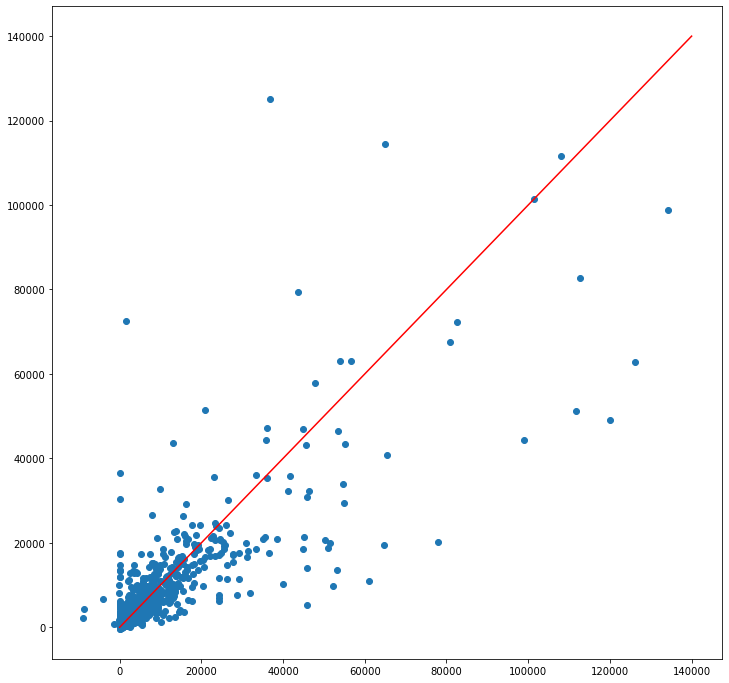

In [101]:
fig, ax = plt.subplots(figsize=(12,12))

x = np.linspace(0,140000, 2)
y = x

ax.scatter(y_val, y_pred_val)
ax.plot(x, y, '-r')


Finally, let's reformat the dataframe into one that can be easily put into the model.

In [13]:
wide_df = longitudinal_cleaned.pivot(index='date', columns=['state', 'county'])
wide_df = wide_df.reorder_levels(["state", "county", None], axis=1)
wide_df.shape

(430, 608)

Written in this way, it's clear that our variable-to-observation ratio is way too high for model prediction. For now, I will focus on Howard County (maryland), with its surrounding counties (Carroll, baltimore, montgomery, anne arundel, and prince george's).

In [14]:
wide_df_subset = wide_df['Maryland'][['Howard', 'Carroll', 'Baltimore', 'Montgomery', 'Anne Arundel', "Prince George's"]]
wide_df_subset

county     Howard                                              Carroll         \
            cases deaths dose1_pop_pct series_complete_pop_pct   cases deaths   
date                                                                            
2021-01-02    123      0           0.0                     0.0      64      0   
2021-01-03     78      0           0.0                     0.0      41      3   
2021-01-04     93      0           0.0                     0.0      38      1   
2021-01-05     87      1           0.0                     0.0      68      3   
2021-01-06    141      0           0.0                     0.0      78      1   
...           ...    ...           ...                     ...     ...    ...   
2022-03-03     25      0          94.5                    84.9      20      0   
2022-03-04     19      0          94.5                    84.9      20      1   
2022-03-05     13      0          94.5                    85.0      18      0   
2022-03-06     14      0          94.6                    85.0       4      0   
2022-03-07     10      0          94.6                    85.0      15      0   

county                                           Baltimore         ...  \
           dose1_pop_pct series_complete_pop_pct     cases deaths  ...   
date                                                               ...   
2021-01-02           0.0                     0.0       350      4  ...   
2021-01-03           0.0                     0.0       257      5  ...   
2021-01-04           0.0                     0.0       243      3  ...   
2021-01-05           0.0                     0.0       175      8  ...   
2021-01-06           0.0                     0.0       402      9  ...   
...                  ...                     ...       ...    ...  ...   
2022-03-03          80.4                    73.3        50      3  ...   
2022-03-04          80.4                    73.3        36      2  ...   
2022-03-05          80.4                    73.3        37      2  ...   
2022-03-06          80.4                    73.3        26      0  ...   
2022-03-07          80.5                    73.3        23      1  ...   

county        Montgomery                         Anne Arundel         \
           dose1_pop_pct series_complete_pop_pct        cases deaths   
date                                                                   
2021-01-02           1.3                     0.0          328      2   
2021-01-03           1.4                     0.0          222      0   
2021-01-04           1.4                     0.0          264      1   
2021-01-05           1.7                     0.0          152      5   
2021-01-06           1.8                     0.0          349      3   
...                  ...                     ...          ...    ...   
2022-03-03          95.0                    85.6           69      3   
2022-03-04          95.0                    85.7           43      1   
2022-03-05          95.0                    85.7           31      0   
2022-03-06          95.0                    85.7           23      0   
2022-03-07          95.0                    85.7           22      0   

county                                           Prince George's         \
           dose1_pop_pct series_complete_pop_pct           cases deaths   
date                                                                      
2021-01-02           0.0                     0.0             555      7   
2021-01-03           0.0                     0.0             334      1   
2021-01-04           0.0                     0.0             363      3   
2021-01-05           0.0                     0.0             422      1   
2021-01-06           0.0                     0.0             473     10   
...                  ...                     ...             ...    ...   
2022-03-03          85.8                    76.1              21      4   
2022-03-04          85.8                    76.2              39     

## Model Building

For now, I would like to start with a 'naive' model -- one that doesn't contain any non-longitudinal census metadata. After previously visualizing the case rates in various Maryland counties (see last notebook), I am inclined to start with a LSTM recurrent neural network in order to better model interactions between the features we are interested in, particularly how cases in one location may influence cases in another. My creation of the LSTM recurrent neural network is largely based off of Hvass Lab's tutorial on using a RNN for weather data. It can be found here: https://github.com/Hvass-Labs/TensorFlow-Tutorials as tutorial 23. After looking through many other tutorials, I believe that this tutorial has data which most closely matches up with the format of my own data, so it will be helpful for me as I use my first neural network model of time series.

I will later do an ARIMA (and potentially a simple GLM) in order to have a more simple model + get more interpretability out of the data.

Again, I aim to predict the cases and deaths in Howard County.

In [15]:
county = "Howard"
vb_to_predict = ['cases', 'deaths']

Let's try to predict the case and death rate 1 week from the given date. We will make a data frame with the "real" values -- these are the values that we want the model to predict, given the input.

In [16]:
shift = 7 # for seven days

shift_vals = wide_df_subset[county][vb_to_predict].shift(-shift)
shift_vals.tail(10) ### I want to make sure that I shifted in the correct direction. It appears to be correct, as the last seven days have null values.

,cases,deaths
date,,
2022-02-26,13.0,0.0
2022-02-27,14.0,0.0
2022-02-28,10.0,0.0
2022-03-01,NaN,NaN
2022-03-02,NaN,NaN
2022-03-03,NaN,NaN
2022-03-04,NaN,NaN
2022-03-05,NaN,NaN
2022-03-06,NaN,NaN


Next, let's make our X and y arrays.

In [17]:
X = wide_df_subset.values[:-shift]
y = shift_vals.values[:-shift]
X.shape, y.shape

((423, 24), (423, 2))

Test-train splitting, and normalizing all values to [0, 1] for the neural network to handle.

In [18]:
train_split = int(0.8 * len(X))
test_split = len(X)-train_split

X_train = X[:train_split]
X_test = X[train_split:]
y_train = y[:train_split]
y_test = y[train_split:]

scaler = MinMaxScaler()
x_train_s = scaler.fit_transform(X_train)
x_test_s = scaler.transform(X_test) 

y_scaler = MinMaxScaler()
y_train_s = y_scaler.fit_transform(y_train)
y_test_s = y_scaler.transform(y_test)

In [19]:
num_x_signals = X.shape[1] # number of inputs per time point
num_y_signals = y.shape[1] # number of outputs per time point

Hvass Labs uses a batch generator function (seen below) to generate batches for training the RNN. Since we only have 400-so observations, I don't believe I will need this, but I will use it anyway because 430 observations may be at the limit of my GPU's memory capacity.

In their case, they have a dataset with over 300k observations. Therefore, if they use a sequence length of 1344, they can still expect that most of their batches will not overlap over the training data. This is not a luxury that I will likely have.

In [20]:
batch_size = 128
sequence_length = 64 # about 2 months

In [21]:
### Taken straight from Hvass Labs' tutorial. In this case, sequence length is the number of consecutive observations that you will want from a batch.

def batch_generator(batch_size, sequence_length):
    """
    Generator function for creating random batches of training-data.
    """

    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, num_x_signals)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length, num_y_signals)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(train_split - sequence_length)
            
            # Copy the sequences of data starting at this index.
            x_batch[i] = x_train_s[idx:idx+sequence_length]
            y_batch[i] = y_train_s[idx:idx+sequence_length]
        
        yield (x_batch, y_batch)

They initialize the batch generator and use it as so:

In [22]:
generator = batch_generator(batch_size=batch_size, sequence_length=sequence_length)
x_batch, y_batch = next(generator)

While we're training on small batches of 32 days, we will do our validation runs on the entire test dataset for hyperparameter tuning. In order to let us feed this entire dataset in, we will have to expand the dimension by 1 to fit the "None" dimension that TensorFlow's API always likes as a wildcard dimension.

In [23]:
validation_data = (np.expand_dims(x_test_s, axis=0), np.expand_dims(y_test_s, axis=0))

## Building the Model with TensorFlow

I was originally going to build this with TensorFlow's functional API (in order to load in the other metadata that's not longitudinal), but I've had a lot of trouble trying to figure out how the longitudinal data will mesh with the non-longitudinal data. For this reason I decided to create my midterm without the other metadata for now, since I can use the (much easier) sequential API. I hope to figure out how to work with the dataframes on the functional API by the final project deadline.

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.backend import square, mean
from tensorflow.keras.layers import Input, GRU, Dense, Embedding

Any RNN will be of the form: Input > Recurrent Units > Dense. Let's initialize it as such. Frankly, I am not sure how many neurons we will need per recurrent layer, so I will set it for now to 128. Hvass used 512 for an input layer of (None, 20,) so it is probably too small, but I can change this later during hyperparameter optimization.

In [25]:
model=Sequential()
model.add(GRU(units=128, return_sequences=True,
              input_shape=(None, num_x_signals,)))
model.add(Dense(num_y_signals, activation='sigmoid')) # I am using sigmoid because I was told to! I am not what alternatives exist for an RNN.

2022-04-04 22:52:33.037621: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-04-04 22:52:33.100282: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-04-04 22:52:33.100569: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-04-04 22:52:33.101487: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate

As with most regression models, we'll use root mean squared error (RMSE) as our loss function. Hvass Labs' tutorial suggests that we don't want the model to "train" on the earliest time steps, as loss value can fluctuate wildly. They give a "warmup" period where the loss function isn't used.

In [26]:
warmup = 10 # Here I am really understanding the problem of "only" having 430 time points.

### again, adapted from Hvass Labs' tutorial. Essentially, this function slices the predicted and true y values to only calculate the RMSE
### with the period after the warmup steps.
def loss_function(y_true, y_pred): 
    y_true_slice = y_true[:, warmup:, :]
    y_pred_slice = y_pred[:, warmup:, :]
    
    mse = mean(square(y_true_slice - y_pred_slice))
    
    return mse

Finally to compile our model.

In [27]:
optimizer = RMSprop(learning_rate=0.001) # This LR is a bit high but we have a function to reduce LR upon plateau...

In [28]:
model.compile(loss=loss_function, optimizer=optimizer)

This TensorFlow tutorial now introduces me to TensorBoard, which is a auto-controller that can make changes to the model between epochs. This is very cool -- previously I would run epoch by epoch to manually control these things, but this provides a convenient alternative. I read through the documentation and am still not completely understanding how it works though, so this code to help monitor and change the model learning process is heavily adapted again from this Hvass Labs tutorial.

In [29]:
path_checkpoint = 'checkpoint.keras'
### this writes checkpoints
callback_checkpoint = ModelCheckpoint(filepath = path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)
### this allows for early stopping if the validation loss continues decreasing upon further training.
callback_early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1) # consider increasing the patience slightly.
### This writes the log during training.
callback_tensorboard = TensorBoard(log_dir = './tensorboard_logs/',
                                   histogram_freq=0,
                                   write_graph=False)
### Finally, this reduces the learning rate upon plateau.
callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=0.0001,
                                       patience=0, # consider changing this to 1
                                       verbose=1)

callbacks = [callback_early_stopping, callback_checkpoint, callback_tensorboard, callback_reduce_lr]

Finally, to train the model.

In [30]:
model.fit(x=generator,
          epochs=100,
          steps_per_epoch=100,
          validation_data=validation_data,
          callbacks=callbacks)

Epoch 1/100


2022-04-04 22:52:37.656258: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8301
2022-04-04 22:52:37.837714: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


 96/100 [===========================>..] - ETA: 0s - loss: 0.0107
Epoch 1: val_loss improved from inf to 0.66048, saving model to checkpoint.keras
100/100 [==============================] - 4s 12ms/step - loss: 0.0105 - val_loss: 0.6605 - lr: 0.0010
Epoch 2/100
 95/100 [===========================>..] - ETA: 0s - loss: 0.0055
Epoch 2: val_loss improved from 0.66048 to 0.62805, saving model to checkpoint.keras
100/100 [==============================] - 1s 8ms/step - loss: 0.0055 - val_loss: 0.6280 - lr: 0.0010
Epoch 3/100
 93/100 [==========================>...] - ETA: 0s - loss: 0.0047
Epoch 3: val_loss did not improve from 0.62805

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
100/100 [==============================] - 1s 8ms/step - loss: 0.0047 - val_loss: 0.6518 - lr: 0.0010
Epoch 4/100
 95/100 [===========================>..] - ETA: 0s - loss: 0.0044
Epoch 4: val_loss did not improve from 0.62805

Epoch 4: ReduceLROnPlateau reducing learning rate to 0

Well, we can see here that the validation loss didn't really decrease at all, suggesting that the model isn't learning anything from the epochs. Also, the stopping at epoch 7 (patience=5) suggests that really only 1 epoch actually "helped" in the learning process. It's possible that this is because the batch size + sample size basically tiles over the entire validation set (which is composed of the entire X_train and y_train).

Next, let's load the best model (which was saved as epoch 2 in the checkpoint).

In [29]:
model.load_weights(path_checkpoint)

In [30]:
result = model.evaluate(x=np.expand_dims(x_test_s, axis=0),
                        y=np.expand_dims(y_test_s, axis=0))

1/1 [==============================] - 0s 13ms/step - loss: 0.6576


Finally, another function heavily influenced by a similar function by Hvass Labs to visualize this data. Essentially, this pulls out a slice of the training dataset of a given length and with a given start index, then plots the real values vs. the predicted values.

In [31]:
def plot_comparison(start, length=100):
    # We just need the end index for slicing the dataframes
    end = start + length
    
    # Select the sequences from the given start-index and
    # of the given length.
    
    
    X = x_train_s[start:end]
    y_true = y_train[start:end]
    
    # We will prepare this "slice" to load into our model for prediction.
    X = np.expand_dims(X, axis=0)

    # This will give us the predicted values from the model.
    y_pred = model.predict(X)
    
    # We have to invert the output (which was in sigmoid)
    # back to the original scale.
    y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])
    
    # We will make a separate graph for each variable to predict.
    for outcome in range(len(vb_to_predict)):
        
        # Here's the prediction with only the two columns that we are interested in.
        outcome_pred = y_pred_rescaled[:, outcome]
        
        # We will also pull these columns out of Y-true.
        outcome_true = y_true[:, outcome]


        plt.figure(figsize=(15,5))

        plt.plot(outcome_true, label='true')
        plt.plot(outcome_pred, label='pred')
        
        # Plot labels etc.
        plt.ylabel(vb_to_predict[outcome])
        plt.legend()
        plt.show()

In [32]:
### essentially the same thing, but for plotting the test set.
def plot_comparison_test(start, length=100):

    end = start + length
    

    X = x_test_s[start:end]
    y_true = y_test[start:end]
    
    # We will prepare this "slice" to load into our model for prediction.
    X = np.expand_dims(X, axis=0)

    # This will give us the predicted values from the model.
    y_pred = model.predict(X)
    
    # We have to invert the output (which was in sigmoid)
    # back to the original scale.
    y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])
    
    # We will make a separate graph for each variable to predict.
    for outcome in range(len(vb_to_predict)):
        
        # Here's the prediction with only the two columns that we are interested in.
        outcome_pred = y_pred_rescaled[:, outcome]
        
        # We will also pull these columns out of Y-true.
        outcome_true = y_true[:, outcome]


        plt.figure(figsize=(15,5))

        plt.plot(outcome_true, label='true')
        plt.plot(outcome_pred, label='pred')
        
        # Plot labels etc.
        plt.ylabel(vb_to_predict[outcome])
        plt.legend()
        plt.show()

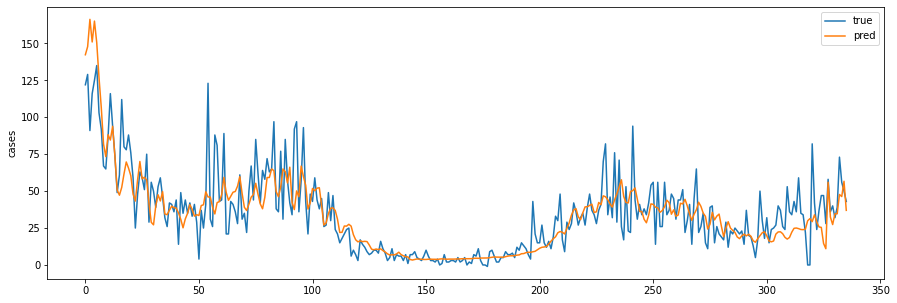

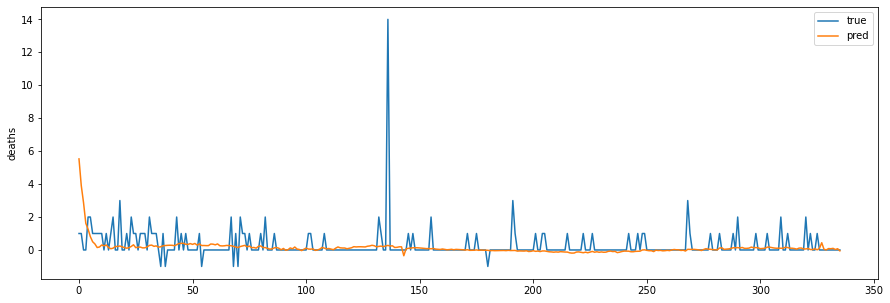

In [33]:
plot_comparison(start=2, length=400)

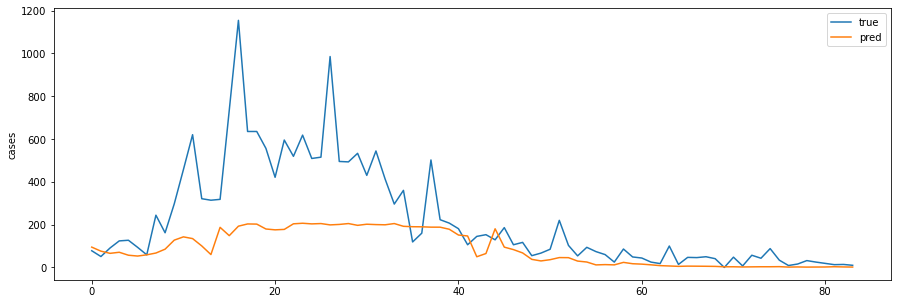

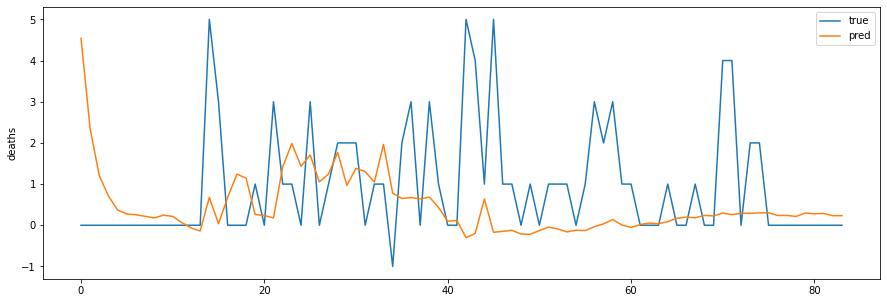

In [34]:
### now to plot the test data:
plot_comparison_test(start=1, length=84)

This is what I was afraid of. While the model is able to fit decently well to case levels on the training set, it is unable to predict the cases in the test set. I am not terribly surprised by this because I am skeptical that the last 3 months of my data (during Omicron) are at all representative of of the data from the previous year. It seems like many hidden variables changed during that time which weren't reflected in the features that I provided to the model.

## Next Steps

It seems clear to me that there are other hidden variables at play that may better predict the movement of COVID cases over time. I suspect that at least some of these hidden variables include demographic/other metadata information that I will load into my model later. However, this initial modelling has suggested that I need more longitudinal data to better forecast COVID Cases. Here are some ideas of my next plans:
1. Drop "deaths" from the dataframe, and focus on simply predicting cases
2. Find other COVID-adjacent, longitudinal data per county. These may include: hospitalizations per county, number of Google searches about COVID per county, etc.
3. Load other metadata into the model
4. Go for more simpler models (i.e. AR time series like ARIMA) to see whether they are competitive against this poor RNN model.
5. Compare my metadata against others provided by the COVID-19 ForecastHub (https://covid19forecasthub.org/reports/single_page.html) in order to see what data sources they use for their ensemble predictions.

## Citations

Hvass Laboratory's tutorial on Recurrent Neural Networks on TensorFlow: https://github.com/Hvass-Labs/TensorFlow-Tutorials

McDonald, Daniel et al., 2021 (https://www.pnas.org/doi/10.1073/pnas.2111453118)

Barcellos, Demian et al., 2021 (https://www.nature.com/articles/s41598-021-04029-6#change-history)

COVID-19 ForecastHub (https://covid19forecasthub.org/reports/single_page.html)
